In [1]:
from pathlib import Path
from typing import Iterable
import re
import os

import pandas as pd
import plotnine as gg
import janitor


In [2]:
_ = gg.theme_set(gg.theme_classic() + gg.theme(axis_ticks=gg.element_blank(), strip_background=gg.element_blank()))
%matplotlib inline
%config InlineBackend.figure_format='retina'

library_pal = {"pymc3": "#12698A", "stan": "#B2001D"}

In [3]:
project_root_dir = Path("..")
benchmarks_dir = project_root_dir / "benchmarks"
n_benchmarks = len(list(benchmarks_dir.iterdir()))
print(f"number of benchmarks: {n_benchmarks}")


number of benchmarks: 9


In [4]:
def read_benchmark(file: Path) -> pd.DataFrame:
    return pd.read_table(file, sep="\t").assign(name=file.name.replace(file.suffix, ""))


def stan_or_pymc3(names: Iterable[str]) -> list[str]:
    return [re.findall("stan|pymc3", n)[0] for n in names]


| colname   |   type (unit)   | description                                                                                                                                                                         |
|-----------|:---------------:|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| s         | float (seconds) | Running time in seconds                                                                                                                                                             |
| h:m:s     |    string (-)   | Running time in hour, minutes, seconds format                                                                                                                                       |
| max_rss   |    float (MB)   | Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used.                                                                                            |
| max_vms   |    float (MB)   | Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process                                                                                       |
| max_uss   |    float (MB)   | “Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now.                                                |
| max_pss   |    float (MB)   | “Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only) |
| io_in     |    float (MB)   | the number of MB read (cumulative).                                                                                                                                                 |
| io_out    |    float (MB)   | the number of MB written (cumulative).                                                                                                                                              |
| mean_load |    float (-)    | CPU usage over time, divided by the total running time (first row)                                                                                                                  |
| cpu_time  |     float(-)    | CPU time summed for user and system                                                                                                                                                 |

In [5]:
benchmarks = (
    pd.concat(read_benchmark(f) for f in benchmarks_dir.iterdir())
    .reset_index(drop=True)
    .assign(
        library=lambda d: stan_or_pymc3(d.name),
        data_size=lambda d: [int(x.split("-")[2]) for x in d.name],
        minutes=lambda d: d.s / 60.0,
    )
)
benchmarks.head()


,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,name,library,data_size,minutes
0,8.8233,0:00:08,671.82,3314.00,154.39,196.26,0.0,1.73,39.49,4.55,simple-stan-1000,stan,1000,0.147055
1,6.6566,0:00:06,670.45,3312.46,169.30,200.78,0.0,0.77,38.87,3.59,simple-stan-1000,stan,1000,0.110943
2,7.6303,0:00:07,671.72,3314.12,140.62,200.60,0.0,1.73,47.33,4.22,simple-stan-1000,stan,1000,0.127172
3,8.2980,0:00:08,671.80,3314.13,169.21,244.59,0.0,1.74,36.02,4.22,simple-stan-1000,stan,1000,0.138300
4,6.2739,0:00:06,675.38,3310.00,135.83,198.91,0.0,0.77,37.84,3.11,simple-stan-1000,stan,1000,0.104565


In [6]:
benchmarks_long = benchmarks[
    [
        "name",
        "library",
        "data_size",
        "minutes",
        "max_rss",
        "max_vms",
        "max_pss",
        "cpu_time",
    ]
].pivot_longer(["name", "library", "data_size"])
benchmarks_long.head()


,name,library,data_size,variable,value
0,simple-stan-1000,stan,1000,minutes,0.147055
1,simple-stan-1000,stan,1000,minutes,0.110943
2,simple-stan-1000,stan,1000,minutes,0.127172
3,simple-stan-1000,stan,1000,minutes,0.138300
4,simple-stan-1000,stan,1000,minutes,0.104565


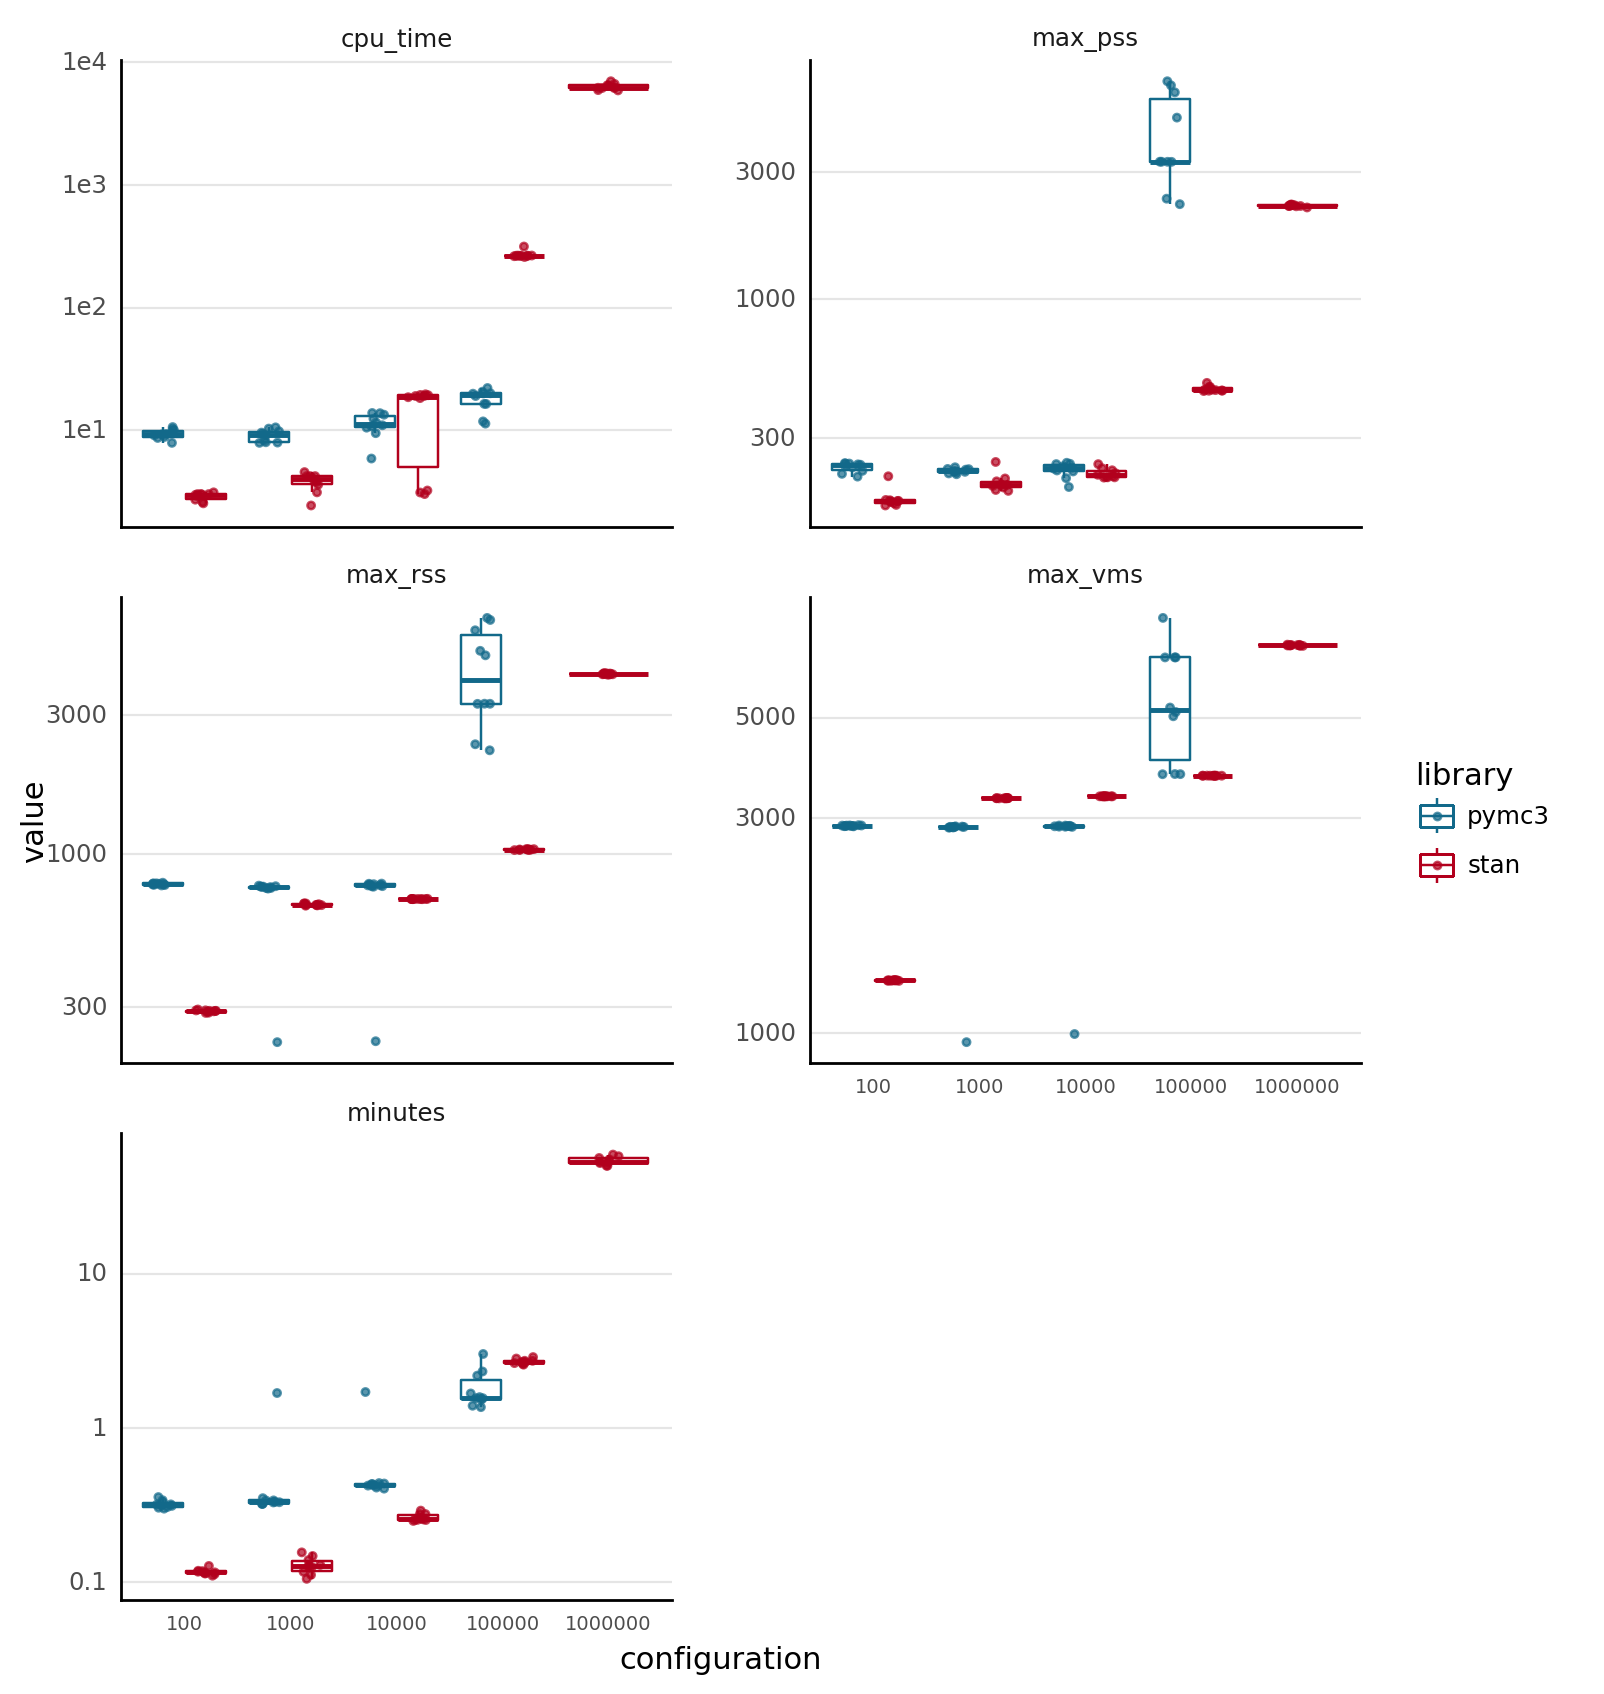

<ggplot: (343593159)>

In [7]:
dpos = gg.position_dodge(width=0.8)
jpos = gg.position_jitterdodge(jitter_width=0.2, jitter_height=0, dodge_width=0.8)
(
    gg.ggplot(
        benchmarks_long, gg.aes(x="factor(data_size)", y="value", color="library")
    )
    + gg.facet_wrap("variable", scales="free_y", ncol=2)
    + gg.geom_boxplot(outlier_alpha=0, position=dpos)
    + gg.geom_jitter(size=1, alpha=0.7, position=jpos)
    + gg.scale_y_log10()
    + gg.scale_color_manual(values=library_pal)
    + gg.theme(
        panel_grid_major_y=gg.element_line(),
        axis_text_x=gg.element_text(size=7),
        subplots_adjust={"wspace": 0.25, "hspace": 0.15},
        figure_size=(8, 10),
    )
    + gg.labs(x="configuration", y="value", color="library")
)


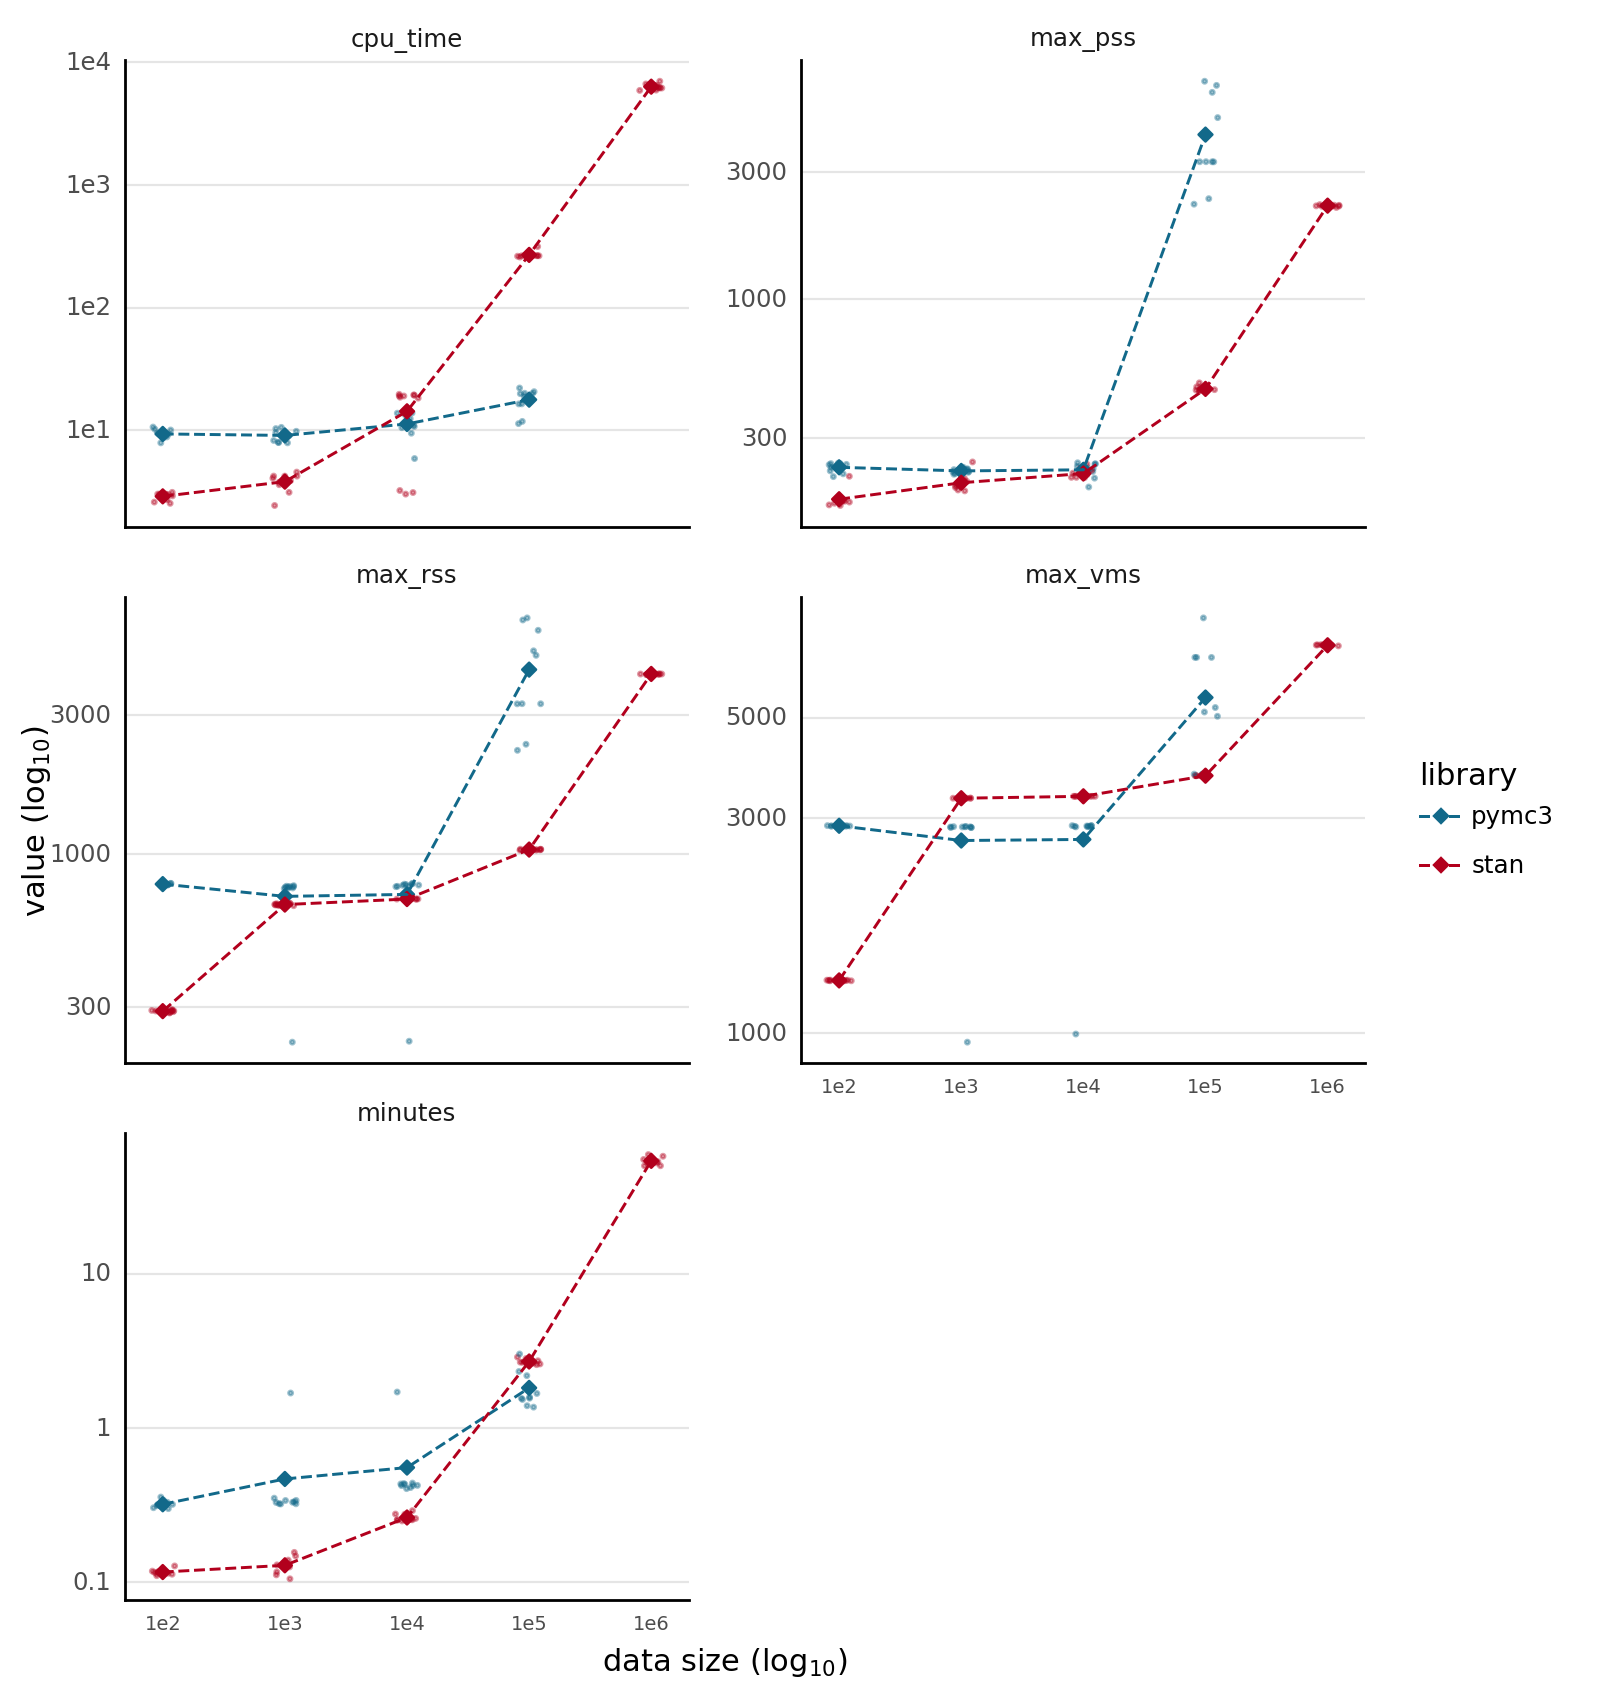

<ggplot: (344012954)>

In [8]:
simple_reg_benchmarks = benchmarks_long.copy()[
    benchmarks_long.name.str.contains("simple")
]
simple_reg_benchmarks_avg = (
    simple_reg_benchmarks.groupby(["variable", "library", "data_size"])
    .mean()
    .reset_index(drop=False)
)


(
    gg.ggplot(simple_reg_benchmarks, gg.aes(x="data_size", y="value", color="library"))
    + gg.facet_wrap("variable", scales="free_y", ncol=2)
    + gg.geom_jitter(size=0.4, alpha=0.4, width=0.1, height=0)
    + gg.geom_point(data=simple_reg_benchmarks_avg, shape="D", size=1.5)
    + gg.geom_line(data=simple_reg_benchmarks_avg, linetype="--", size=0.6)
    + gg.scale_x_log10()
    + gg.scale_y_log10()
    + gg.scale_color_manual(values=library_pal)
    + gg.theme(
        panel_grid_major_y=gg.element_line(),
        axis_text_x=gg.element_text(size=7),
        subplots_adjust={"wspace": 0.2, "hspace": 0.15},
        figure_size=(8, 10),
    )
    + gg.labs(x="data size ($\\log_{10}$)", y="value ($\\log_{10}$)", color="library")
)


In [9]:
def read_file_sizes(dir: Path) -> pd.DataFrame:
    files = list(dir.iterdir())
    sizes = pd.Series([os.path.getsize(f) for f in files])
    sizes_mb = sizes / 1000000.0
    return pd.DataFrame(
        {
            "file": files,
            "name": [f.name.replace(f.suffix, "") for f in files],
            "bytes": sizes,
            "mb": sizes_mb,
        }
    )


In [10]:
result_file_sizes = read_file_sizes(project_root_dir / "model-results").assign(
    model=lambda d: stan_or_pymc3(d.name),
    mb_lbl=lambda d: [f"{int(x)} MB" for x in d.mb],
)

(
    gg.ggplot(result_file_sizes, gg.aes(x="name", y="mb", fill="model"))
    + gg.geom_col()
    + gg.geom_text(gg.aes(label="mb_lbl"), nudge_y=10)
    + gg.scale_fill_brewer(type="qual", palette="Set1")
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0), limits=(0, None))
    + gg.theme(
        panel_grid_major_y=gg.element_line(), axis_text_x=gg.element_text(size=7)
    )
    + gg.labs(x="configuration", y="pickled result file (MB)", fill="library")
)


/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_33291/2506346805.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TypeError: '>' not supported between instances of 'NoneType' and 'NoneType'